In [1]:
%matplotlib inline
from matplotlib import style

style.use("fivethirtyeight")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect, desc
import os
from pprint import pprint

In [5]:
db_path = os.path.join("Resources", "hawaii.sqlite")
engine = create_engine(f"sqlite:///{db_path}")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

Column: id
Column: station
Column: date
Column: prcp
Column: tobs
Column: id
Column: station
Column: name
Column: latitude
Column: longitude
Column: elevation
('2017-08-23',)


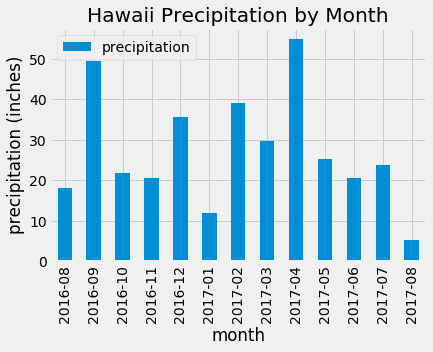

In [9]:
# Create our session (link) from Python to the DB

from sqlalchemy import inspect

inspector = inspect(engine)

for table_name in inspector.get_table_names():
    for column in inspector.get_columns(table_name):
        print("Column: %s" % column["name"])

session = Session(engine)
# this finds that latest date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
cmd = session.query(func.max(Measurement.date))

for row in cmd:
    print(row)

# With previous query I found that the latest date was 2017-08-23

test_rows = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(
        Measurement.date >= (dt.datetime.strptime("2016-08-23", "%Y-%m-%d"))
    )
    .order_by(Measurement.date)
)


df = pd.read_sql(test_rows.statement, test_rows.session.bind)

df.set_index("date")
df.fillna(0)

df["month"] = pd.to_datetime(df["date"]).dt.to_period("M")

test = df.groupby(["month"], as_index=False)["prcp"].agg("sum")

test.columns = ["month", "precipitation"]

test


ax = test.plot(
    kind="bar",
    x="month",
    y="precipitation",
    title="Hawaii Precipitation by Month",
)

ax.set_ylabel("precipitation (inches)")

plt.savefig("hawaii_precipitation_plot.png")


plt.show()

 # Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [10]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

# This may be different because at one point I erased NaN values with Dropna.

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [11]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(func.count(Station.name)).distinct()


station_count_df = pd.read_sql(
    stations_count.statement, stations_count.session.bind
)
print(station_count_df)

   count_1
0        9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


station_frequency_count = (
    session.query(
        Measurement.id, Measurement.station, func.count(Measurement.station)
    )
    .group_by(Measurement.station)
    .order_by(desc(func.count(Measurement.station)))
    .all()
)


print(station_frequency_count)


# The station with the highest frequencies is 'USC00519281'

[(12188, 'USC00519281', 2772), (1, 'USC00519397', 2724), (2725, 'USC00513117', 2709), (9519, 'USC00519523', 2669), (16939, 'USC00516128', 2612), (5434, 'USC00514830', 2202), (14960, 'USC00511918', 1979), (7636, 'USC00517948', 1372), (9008, 'USC00518838', 511)]


In [13]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature most active station?

max_min_avg = session.query(
    func.max(Measurement.tobs),
    func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
).filter(Measurement.station == "USC00519281")

for row in max_min_avg:
    print(row)
# These are the maximum, minimum, and average temperatures for station 'USC00519281' respectively.

(85.0, 54.0, 71.66378066378067)


In [14]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

station_temp_count = (
    session.query(
        Measurement.id,
        Measurement.station,
        func.count(Measurement.tobs),
        func.count(Measurement.station),
    )
    .group_by(Measurement.station)
    .all()
)

for row in station_temp_count:
    print(row)

# Again the station with the highest number of temperature observations is 'USC00519281'
temp_data = (
    session.query(Measurement.date, Measurement.tobs, Measurement.station)
    .filter(
        Measurement.date >= (dt.datetime.strptime("2016-08-23", "%Y-%m-%d"))
    )
    .order_by(Measurement.date)
    .filter(Measurement.station == "USC00519281")
)


temp_df = pd.read_sql(temp_data.statement, test_rows.session.bind)

temp_df

(14960, 'USC00511918', 1979, 1979)
(2725, 'USC00513117', 2709, 2709)
(5434, 'USC00514830', 2202, 2202)
(16939, 'USC00516128', 2612, 2612)
(7636, 'USC00517948', 1372, 1372)
(9008, 'USC00518838', 511, 511)
(12188, 'USC00519281', 2772, 2772)
(1, 'USC00519397', 2724, 2724)
(9519, 'USC00519523', 2669, 2669)


,date,tobs,station
0,2016-08-24,77.0,USC00519281
1,2016-08-25,80.0,USC00519281
2,2016-08-26,80.0,USC00519281
3,2016-08-27,75.0,USC00519281
4,2016-08-28,73.0,USC00519281
...,...,...,...
346,2017-08-14,77.0,USC00519281
347,2017-08-15,77.0,USC00519281
348,2017-08-16,76.0,USC00519281
349,2017-08-17,76.0,USC00519281


In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d'
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """

    return (
        session.query(
            func.min(Measurement.tobs),
            func.avg(Measurement.tobs),
            func.max(Measurement.tobs),
        )
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .all()
    )


# function usage example
print(calc_temps("2012-02-28", "2012-03-05"))

[(62.0, 69.57142857142857, 74.0)]


In [16]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax
# for your trip using the previous year's data for those same dates.
# I chose the same dates for my trip because the temperature seemed nice!
print(calc_temps("2016-02-28", "2016-03-05"))

[(62.0, 69.88636363636364, 80.0)]


In [17]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

In [18]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


def calc_rain(start_date, end_date):
    return (
        session.query(
            Measurement.station,
            func.sum(Measurement.prcp),
            Station.name,
            Station.latitude,
            Station.longitude,
            Station.elevation,
        )
        .group_by(Measurement.station)
        .filter(Measurement.date >= start_date)
        .filter(Measurement.date <= end_date)
        .filter(Measurement.station == Station.station)
        .order_by(func.sum(Measurement.prcp).desc())
        .all()
    )


# The query is equivalent to a join with Measurement.station==Station.station.

# I remade the function to find the total precipitation between the dates at each station. However, for some reason
# I am only getting seven stations.

result = calc_rain("2016-02-13", "2016-02-20")

for row in result:
    print(row)

('USC00516128', 1.07, 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)
('USC00514830', 0.57, 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
('USC00519523', 0.51, 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
('USC00519281', 0.44, 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
('USC00513117', 0.37, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
('USC00519397', 0.29, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)


## Optional Challenge Assignment

In [19]:
# Create a query that will calculate the daily normals
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)


def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """

    sel = [
        func.min(Measurement.tobs),
        func.avg(Measurement.tobs),
        func.max(Measurement.tobs),
    ]
    return (
        session.query(*sel)
        .filter(func.strftime("%m-%d", Measurement.date) == date)
        .all()
    )


daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [20]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

In [21]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [22]:
# Plot the daily normals as an area plot with `stacked=False`